In [84]:
import matplotlib.pyplot as plt
import sys
import scipy as sp
import numpy as np
import time
import os
from xpcs_viewer import XpcsFile as xf
import scipy.optimize as op
import h5py
from scipy.integrate import cumtrapz

In [85]:
def read_parameters(fname):
    if fname.endswith('.txt'):
        paras = np.loadtxt(fname)
    elif fname.endswith('.csv'):
        paras = np.loadtxt(fname, delimiter=',')
    else:
        paras = None
    return paras

def cumulative_sum(array):
    result = []
    total = 0
    for num in array:
        total += num
        result.append(total)
    return result

def IntegralMat2(Array):
    length = len(Array)
    cs = np.cumsum(Array)
    mat1 = np.tile(cs, length).reshape(length, length)
    deltaMat = np.abs(mat1 - mat1.T)
    return deltaMat

def fix_diagonal_c2(c2_3d):
    c2_all = []
    for n in range(c2_3d.shape[0]):
        c2 = c2_3d[n]
        size = c2.shape[0]
        side_band = c2[(np.arange(size - 1), np.arange(1, size))]
        diag_val = np.zeros(size)
        diag_val[:-1] += side_band
        diag_val[1:] += side_band
        norm = np.ones(size)
        norm[1:-1] = 2
        c2[np.diag_indices(c2.shape[0])] = diag_val / norm
    
    return c2_3d

def read_parameters(fname):
    if fname.endswith('.txt'):
        paras = np.loadtxt(fname)
    elif fname.endswith('.csv'):
        paras = np.loadtxt(fname, delimiter=',')
    else:
        paras = None
    return paras

def read_data(ExpCode):
    # save_folder = '/home/8ididata/2022-3/hongrui202210/NonequilibratedAnalysis'
    # DataFolderPath = 'data_Twotime'
    # DataFolderName = fname
    # Object = xf(os.path.join(DataFolderPath, DataFolderName), cwd='')
    # ExpCode = fname[0:4]
    print(ExpCode)
    
    phi_list = np.loadtxt('phi_list.txt')
    phi_length = len(phi_list)
    CreepStart = 1001
    CreepEnd = 2000

    t_length = CreepEnd - CreepStart

    cache_fname = f'c2_cache_{CreepStart}_{CreepEnd}.npz'

    if os.path.isfile(os.path.join(ExpCode,cache_fname)):
        c2_exp = np.load(os.path.join(ExpCode,cache_fname))['c2_exp'].astype(DTYPE)
    else:
        c2_exp = np.zeros((phi_length, t_length, t_length), dtype=DTYPE)
        for phiIdx, phi in enumerate(phi_list):
            cMat = Object.get_twotime_c2(
                    'exchange', phiIdx+1)[CreepStart:CreepEnd, CreepStart:CreepEnd]
            c2_exp[phiIdx] = cMat
        np.savez(os.path.join(ExpCode,cache_fname), c2_exp=c2_exp)
    
    # fix the diagonal line
    c2_exp = fix_diagonal_c2(c2_exp)
    return c2_exp.astype(DTYPE), t_length, phi_list.astype(DTYPE), phi_length

def HomodyneC020(x, phi_list):
    phi_length = len(phi_list) 
    x = x.astype(DTYPE)
    t_length = 999
    num_d = 3
    num_v = 3
    
    D_c  = x[0:num_d]
    v_c  = x[num_d: num_d + num_v]
    phio = x[num_d + num_v]
    beta = x[num_d + num_v + 1: num_d + num_v + phi_length + 1]
    c = x[num_d + num_v + phi_length + 1: num_d + num_v + 2 * phi_length + 1]
    
    tabs = np.linspace(0.1, 99.9, t_length, dtype=DTYPE) 
    v = v_c[0]*(tabs)**v_c[1] + v_c[2]
    D = D_c[0]*(tabs)**D_c[1] + D_c[2]
    
    DMat = IntegralMat2(D)
    vMat = IntegralMat2(v)
    
    dt = 0.1
    qValue = 0.0054
    gap = 200 * 10000
    
    g1_s = np.exp(-abs((qValue**2/2 * DMat * dt))).astype(DTYPE)
    g2_all = np.zeros((phi_length, t_length, t_length), dtype=DTYPE)

    for n in range(phi_length):
        w = np.sinc(1/2 /np.pi * qValue* gap * vMat * dt * np.cos(np.deg2rad(phio - phi_list[n]))) 
        g2_all[n] = c[n] + beta[n] * (w * g1_s ) **2
    return g2_all

def HeterodyneC044(x, phi_list):
    phi_length = len(phi_list) 
    x = x.astype(DTYPE)
    t_length = 999
    num_d = 3
    num_v = 3
    num_f = 4
    
    D_c  = x[0:num_d]
    v_c  = x[num_d: num_d + num_v]
    f_c  = x[num_d + num_v:num_d + num_v + num_f]
    phio = x[num_d + num_v + num_f]
    beta = x[num_d + num_v + num_f + 1: num_d + num_v + num_f + phi_length + 1]
    c    = x[num_v + num_f + num_d + phi_length + 1:num_v + num_f + num_d + 2*phi_length + 1]    

    tabs = np.linspace(0.1, 99.9, t_length, dtype=DTYPE)
    v = v_c[0]*(tabs)**v_c[1] + v_c[2]
    D = D_c[0]*(tabs)**D_c[1] + D_c[2]
    f = f_c[0] * np.exp(f_c[1]*(tabs - f_c[2])) + f_c[3]

    f1s,f2s = np.meshgrid(f,f)
    f1r = 1 - f1s
    f2r = 1 - f2s
    ftotal = np.sqrt((f1s**2 + f1r**2) * (f2s**2 + f2r**2))
    
    DMat = IntegralMat2(D)
    vMat = IntegralMat2(v)

    dt = 0.1
    qValue = 0.0054

    g1_r = 1.0
    g1_s = np.exp(-abs((qValue**2/2 * DMat * dt))).astype(DTYPE)
    g2_all = np.zeros((phi_length, t_length, t_length), dtype=DTYPE)
    t0 = (f1r*f2r*g1_r) ** 2 + (f1s*f2s*g1_s) ** 2

    for n in range(phi_length):
        w = np.cos(qValue * vMat * dt * np.cos(np.deg2rad(phio - phi_list[n])))
        g2_all[n] = c[n] + beta[n] * (t0 +  2*f1s*f2s*f1r*f2r* w * g1_s)/ftotal**2

    return g2_all


def HeterodyneC045(x, phi_list):
    phi_length = len(phi_list) 
    x = x.astype(DTYPE)
    t_length = 999
    num_d = 5
    num_v = 4
    num_f = 4
    
    D_c  = x[0:num_d]
    v_c  = x[num_d: num_d + num_v]
    f_c  = x[num_d + num_v:num_d + num_v + num_f]
    phio = x[num_d + num_v + num_f]
    
    beta = x[num_d + num_v + num_f + 1: num_d + num_v + num_f + phi_length + 1]
    c    = x[num_v + num_f + num_d + phi_length + 1:num_v + num_f + num_d + 2*phi_length + 1]
    
    tabs = np.linspace(0.1, 99.9, t_length, dtype=DTYPE) 
    v = np.polynomial.Polynomial(v_c)(tabs)
    D = np.polynomial.Polynomial(D_c)(tabs)
    f = np.polynomial.Polynomial(f_c)(tabs)
    f1s,f2s = np.meshgrid(f,f)
    f1r = 1 - f1s
    f2r = 1 - f2s
    ftotal = np.sqrt((f1s**2 + f1r**2) * (f2s**2 + f2r**2))
    
    DMat = IntegralMat2(D)
    vMat = IntegralMat2(v)
    
    dt = 0.1
    qValue = 0.0054

    g1_r = 1.0
    g1_s = np.exp(-abs((qValue**2/2 * DMat * dt))).astype(DTYPE)
    g2_all = np.zeros((phi_length, t_length, t_length), dtype=DTYPE)
    t0 = (f1r*f2r*g1_r) ** 2 + (f1s*f2s*g1_s) ** 2

    for n in range(phi_length):
        w = np.cos(qValue * vMat * dt * np.cos(np.deg2rad(phio - phi_list[n])))
        g2_all[n] = c[n] + beta[n] * (t0 +  2*f1s*f2s*f1r*f2r * w * g1_s) / ftotal**2
    return g2_all

def HeterodyneC046_in(x, phi_list):
    phi_length = len(phi_list) 
    x = x.astype(DTYPE)
    t_length = 210
    num_d = 3
    num_v = 3
    num_f = 3
    
    D_c  = x[0:num_d]
    v_c  = x[num_d: num_d + num_v]
    f_c  = x[num_d + num_v:num_d + num_v + num_f]
    phio = x[num_d + num_v + num_f]
    
    beta = x[num_d + num_v + num_f + 1: num_d + num_v + num_f + phi_length + 1]
    c    = x[num_v + num_f + num_d + phi_length + 1:num_v + num_f + num_d + 2*phi_length + 1]
    
    tabs = np.linspace(0.1, 0.1*t_length, t_length, dtype=DTYPE)
    v = v_c[0]*(tabs)**v_c[1] + v_c[2]
    D = D_c[0]*(tabs)**D_c[1] + D_c[2]
    f = 1 - f_c[0]*np.exp((tabs - f_c[2])*f_c[1])
    f1s,f2s = np.meshgrid(f,f)
    f1r = 1 - f1s
    f2r = 1 - f2s
    ftotal = np.sqrt((f1s**2 + f1r**2) * (f2s**2 + f2r**2))
    
    DMat = IntegralMat2(D)
    vMat = IntegralMat2(v)
    
    dt = 0.1
    qValue = 0.0054

    g1_r = 1.0
    g1_s = np.exp(-abs((qValue**2/2 * DMat * dt))).astype(DTYPE)
    g2_all = np.zeros((phi_length, t_length, t_length), dtype=DTYPE)
    t0 = (f1r*f2r*g1_r) ** 2 + (f1s*f2s*g1_s) ** 2

    for n in range(phi_length):
        w = np.cos(qValue * vMat * dt * np.cos(np.deg2rad(phio - phi_list[n])))
        g2_all[n] = c[n] + beta[n] * (t0 +  2*f1s*f2s*f1r*f2r* w * g1_s)/ ftotal**2
    return g2_all


def HeterodyneC046_de(x, phi_list):
    global t_length
    global startpoint
    phi_length = len(phi_list) 
    x = x.astype(DTYPE)
    t_length = 749
    num_d = 3
    num_v = 3
    num_f = 4
    
    D_c  = x[0:num_d]
    v_c  = x[num_d: num_d + num_v]
    f_c  = x[num_d + num_v:num_d + num_v + num_f]
    phio = x[num_d + num_v + num_f]
    
    beta = x[num_d + num_v + num_f + 1: num_d + num_v + num_f + phi_length + 1]
    c    = x[num_v + num_f + num_d + phi_length + 1:num_v + num_f + num_d + 2*phi_length + 1]
    
    tabs = np.linspace((startpoint+1)*0.1, 99.9, t_length, dtype=DTYPE)
    v = v_c[0]*(tabs)**v_c[1] + v_c[2]
    D = D_c[0]*(tabs)**D_c[1] + D_c[2]
    f = f_c[0] * np.exp(f_c[1]*(tabs - f_c[2])) + f_c[3]
    f1s,f2s = np.meshgrid(f,f)
    f1r = 1 - f1s
    f2r = 1 - f2s
    ftotal = np.sqrt((f1s**2 + f1r**2) * (f2s**2 + f2r**2))
    DMat = IntegralMat2(D)
    vMat = IntegralMat2(v)
    
    dt = 0.1
    qValue = 0.0054

    g1_r = 1.0
    g1_s = np.exp(-abs((qValue**2/2 * DMat * dt))).astype(DTYPE)
    g2_all = np.zeros((phi_length, t_length, t_length), dtype=DTYPE)
    t0 = (f1r*f2r*g1_r) ** 2 + (f1s*f2s*g1_s) ** 2

    for n in range(phi_length):
        w = np.cos(qValue * vMat * dt * np.cos(np.deg2rad(phio - phi_list[n])))
        g2_all[n] = c[n] + beta[n] * (t0 +  2*f1s*f2s*f1r*f2r* w * g1_s)/ ftotal**2
    return g2_all

def letter_annotation(ax, xoffset, yoffset, letter):
     ax.text(xoffset, yoffset, letter, transform=ax.transAxes,
         size=16, weight='bold')


In [86]:
DTYPE = np.float32
cmap = 'turbo'
p3color = 'C0'
p2color = 'C1'
p1color = 'C2'
p3marker = 'o'
p2marker = 's'
p1marker = '^'

r = 1.1e8 / 2
gap = 2e6
t_length = 999
tabs = np.linspace(0.1, 99.9, t_length)
SelectedIdx = np.unique(np.logspace(0,2,40).astype(int) - 1)
tabs_color = 'white'
    
linestyle = '--'
alpha = 0.5



In [87]:
def plot_fig1():
    
    #C020
    fname = 'C020'
    c2_exp, t_length, phi_list, phi_length = read_data(fname)
    paras = read_parameters('FitParas/C020_FitParas.txt')
    c2_fit = HomodyneC020(paras, phi_list)
    
    g2Plot = np.tril(c2_exp[SelectedPhiIdx,:,:]) + np.triu(c2_fit[SelectedPhiIdx,:,:])
    
    img = ax1.imshow(g2Plot,vmin=1.1, vmax= 1.3, cmap=cmap)
    cbar = plt.colorbar(img,ax=ax1,orientation = 'vertical',pad=-0.03,shrink = shrink)
    cbar.set_ticks([1.1, 1.2, 1.3])
    cbar.set_ticklabels(['1.1', '1.1', '1.3'], fontsize = axis_fontsize)
    
    ax1.plot(np.linspace(0,1000,11),np.linspace(0,1000,11),marker='1',color=tabs_color)
    for tabs_marker in np.linspace(200,800,4):
        ax1.text(tabs_marker,tabs_marker,'%d' % int(tabs_marker/10),color=tabs_color,horizontalalignment='right',verticalalignment='bottom')
    ax1.invert_yaxis()
    ax1.set_xticks(np.linspace(0,1000,6))
    ax1.set_xticklabels(np.linspace(0,100,6).astype(int), fontsize = axis_fontsize)
    ax1.set_yticks(np.linspace(0,1000,6))
    ax1.set_yticklabels(np.linspace(0,100,6).astype(int), fontsize = axis_fontsize)
    minor_ticks = np.linspace(0,1000,11)
    ax1.xaxis.set_minor_locator(plt.FixedLocator(minor_ticks))
    ax1.yaxis.set_minor_locator(plt.FixedLocator(minor_ticks)) 
    ax1.set_xlim(0,1000)
    ax1.set_ylim(0,1000)
    ax1.set_xlabel('$t_{1} [s]$', fontsize = axis_fontsize)
    ax1.set_ylabel('$t_{2} [s]$', fontsize = axis_fontsize)

In [88]:
def plot_fig2():

    # C020
    paras = read_parameters('FitParas/C020_FitParas.txt')
    num_d = 3
    num_v = 3   
    D_c  = paras[0:num_d]
    v_c  = paras[num_d: num_d + num_v]
    v = v_c[0]*(tabs)**v_c[1] + v_c[2]
    D = D_c[0]*(tabs)**D_c[1] + D_c[2]
    
    save_folder = '../RheoResult/'
    RheoResult_Creep = np.loadtxt(os.path.join(save_folder,'C020_RheoResult_Creep.csv'),delimiter=',')
    Time = RheoResult_Creep[:,0]
    ShearRate = abs(RheoResult_Creep[:,1])
    ShearStress = RheoResult_Creep[:,2]
    ShearStrain = RheoResult_Creep[:,8]
    
    ax2.scatter(Time[SelectedIdx],ShearRate[SelectedIdx],color=p1color,facecolor='none',marker=p1marker)
    ax2.plot(tabs,v, color=p1color,linewidth=2, label = '20Pa')
    ax1.plot(tabs,D, color=p1color,linewidth=2, linestyle = linestyle, alpha = alpha)
    
    
    # C021
    paras = read_parameters('FitParas/C021_FitParas.txt')
    num_d = 3
    num_v = 3   
    D_c  = paras[0:num_d]
    v_c  = paras[num_d: num_d + num_v]
    v = v_c[0]*(tabs)**v_c[1] + v_c[2]
    D = D_c[0]*(tabs)**D_c[1] + D_c[2]
    
    RheoResult_Creep = np.loadtxt(os.path.join(save_folder,'C021_RheoResult_Creep.csv'),delimiter=',')
    Time = RheoResult_Creep[:,0]
    ShearRate = abs(RheoResult_Creep[:,1])
    ShearStress = RheoResult_Creep[:,2]
    ShearStrain = RheoResult_Creep[:,8]
    
    ax2.scatter(Time[SelectedIdx],ShearRate[SelectedIdx], color=p2color,facecolor='none',marker=p2marker)
    ax2.plot(tabs,v, color=p2color,linewidth=2, label = '25Pa')
    ax1.plot(tabs,D, color=p2color,linewidth=2, linestyle = linestyle, alpha = alpha)
    
    
    # C023
    paras = read_parameters('FitParas/C023_FitParas.txt')
    num_d = 3
    num_v = 3   
    D_c  = paras[0:num_d]
    v_c  = paras[num_d: num_d + num_v]
    v = v_c[0]*(tabs)**v_c[1] + v_c[2]
    D = D_c[0]*(tabs)**D_c[1] + D_c[2]
    
    RheoResult_Creep = np.loadtxt(os.path.join(save_folder,'C023_RheoResult_Creep.csv'),delimiter=',')
    Time = RheoResult_Creep[:,0]
    ShearRate = abs(RheoResult_Creep[:,1])
    ShearStress = RheoResult_Creep[:,2]
    ShearStrain = RheoResult_Creep[:,8]
    
    ax2.scatter(Time[SelectedIdx],ShearRate[SelectedIdx], color=p3color,facecolor='none',marker=p3marker)
    ax2.plot(tabs,v, color=p3color,linewidth=2, label = '30Pa')
    ax1.plot(tabs,D, color=p3color,linewidth=2, linestyle = linestyle)
    
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_ylabel("$\dot{γ}$ [1/s]", fontsize = axis_fontsize)
    
    ax2.plot(np.array([10,50]),np.array([10,50])**(-2/3)*8e-4,color='black')
    ax2.text(10,15**(-2/3)* 1.6e-4, '~$t^{-\dfrac{2}{3}}$', \
             color='black',horizontalalignment='right',verticalalignment='bottom')
    
    ax1.plot(1, 1 , label = '$J$:XPCS', color='k', linestyle = linestyle, alpha = alpha)
    ax1.plot(1, 1 , label = r'$\dot{γ}$:XPCS', color='k')
    ax1.scatter(1, 1 , label = r'$\dot{γ}$:Rheo', color='k',facecolor='none',marker=p3marker)
    
    minor_ticks = np.concatenate([np.arange(1,10,1).astype(np.float32) * 10**exp for exp in np.arange(-5,-1).astype(np.float32)])
    ax2.yaxis.set_minor_locator(plt.FixedLocator(minor_ticks))
    ax2.set_yticks([1e-4, 1e-3,1e-2,1e-1])
    ax2.set_ylim(3e-5, 2e-1)
    ax2.set_yticklabels(['10$^{-4}$','10$^{-3}$','10$^{-2}$','10$^{-1}$'], fontsize = axis_fontsize)
    ax2.legend(loc = 'upper right', framealpha=0, fontsize = 9, labelspacing = 0, handlelength = 1.5)

    
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.set_ylabel('$J [Å^{2}/s]$', alpha = alpha, fontsize = axis_fontsize)
    ax1.tick_params(axis='both',which='both',labelsize=axis_fontsize)
    ax1.set_xlim(0.5,120)
    ax1.set_ylim(0.9e3,4.5e5)
    ax1.set_xlabel('t [s]', fontsize = axis_fontsize)
    
    minor_ticks = np.concatenate([np.arange(1,10,1).astype(np.float32) * 10**exp for exp in np.arange(-2,6).astype(np.float32)])
    ax1.yaxis.set_minor_locator(plt.FixedLocator(minor_ticks))


In [89]:
def plot_fig3():
    
    g2Plot = None
    fname = 'C044'
    c2_exp, t_length, phi_list, phi_length = read_data(fname)
    paras = paras = read_parameters('FitParas/C044_FitParas.txt')
    c2_fit = HeterodyneC044(paras, phi_list)
    g2Plot = np.tril(c2_exp[SelectedPhiIdx,:,:]) + np.triu(c2_fit[SelectedPhiIdx,:,:])
    
    img = ax4.imshow(g2Plot,vmin=1.1, vmax= 1.3, cmap=cmap)
    cbar = plt.colorbar(img,ax=ax4,orientation = 'vertical',pad=-0.03,shrink = shrink)
    cbar.set_ticks([1.1, 1.2, 1.3])
    cbar.set_ticklabels(['1.1', '1.1', '1.3'], fontsize = axis_fontsize)
    
    ax4.plot(np.linspace(0,1000,11),np.linspace(0,1000,11),marker='1',color=tabs_color)
    for tabs_marker in np.linspace(200,800,4):
        ax4.text(tabs_marker,tabs_marker,'%d' % int(tabs_marker/10),color=tabs_color,horizontalalignment='right',verticalalignment='bottom')
    ax4.invert_yaxis()
    ax4.set_xticks(np.linspace(0,1000,6))
    ax4.set_xticklabels(np.linspace(0,100,6).astype(int), fontsize = axis_fontsize)
    ax4.set_yticks(np.linspace(0,1000,6))
    ax4.set_yticklabels(np.linspace(0,100,6).astype(int), fontsize = axis_fontsize)
    minor_ticks = np.linspace(0,1000,11)
    ax4.xaxis.set_minor_locator(plt.FixedLocator(minor_ticks))
    ax4.yaxis.set_minor_locator(plt.FixedLocator(minor_ticks)) 
    ax4.set_xlim(0,1000)
    ax4.set_ylim(0,1000)
    ax4.set_xlabel('$t_{1} [s]$', fontsize = axis_fontsize)
    ax4.set_ylabel('$t_{2} [s]$', fontsize = axis_fontsize)

In [90]:
def plot_fig4():
    
    # paras = paras = read_parameters('FitParas/C044_FitParas.txt')
    paras = paras = read_parameters('FitParas/C044_FitParas.txt')
    num_d = 3
    num_v = 3
    num_f = 4
    t_length = 999
    
    D_c  = paras[0:num_d]
    v_c  = paras[num_d: num_d + num_v]
    f_c  = paras[num_d + num_v:num_d + num_v + num_f]
    
    tabs = np.linspace(0.1, 99.9, t_length)
    v = v_c[0]*(tabs)**v_c[1] + v_c[2]
    D = D_c[0]*(tabs)**D_c[1] + D_c[2]
    f = f_c[0] * np.exp(f_c[1]*(tabs - f_c[2])) + f_c[3]
    
    save_folder = '../RheoResult/'
    RheoResult_Creep = np.loadtxt(os.path.join(save_folder,'C044_RheoResult_Creep.csv'),delimiter=',')
    Time = RheoResult_Creep[:,0]
    ShearRate = RheoResult_Creep[:,1]
    ShearStress = RheoResult_Creep[:,2]
    ShearStrain = RheoResult_Creep[:,8]
    RevSpeed = RheoResult_Creep[:,9]
    TangentialVelocity = ShearRate * gap / 2
    
    ax3.scatter(Time[SelectedIdx],TangentialVelocity[SelectedIdx], color=p1color,facecolor='none',marker=p1marker)
    ax3.plot(tabs,v, color=p1color,linewidth=2, label = '100 Pa')
    ax2.plot(tabs,D, color=p1color,linewidth=2, linestyle = linestyle, alpha = alpha)
    
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.set_ylabel("v$_{Edge}$ [Å/s]", fontsize=axis_fontsize)
    minor_ticks = np.concatenate([np.arange(1,10,1).astype(np.float32) * 10**exp for exp in np.arange(0,4).astype(np.float32)])
    ax3.yaxis.set_minor_locator(plt.FixedLocator(minor_ticks))
    ax3.set_xlim(0.5,120)
    ax3.set_ylim(1e0,1e4)
    
    ax2.set_yscale('log')
    ax2.set_ylabel('$J[Å^{2}/s]$', alpha = alpha, fontsize=axis_fontsize)
    minor_ticks = np.concatenate([np.arange(1,10,1).astype(np.float32) * 10**exp for exp in np.arange(0,4).astype(np.float32)])
    ax2.yaxis.set_minor_locator(plt.FixedLocator(minor_ticks))
    ax2.set_ylim(1e1,1e4)
    ax2.set_xlim(0.5,120)
    ax2.set_xlabel('t [s]',fontsize=axis_fontsize)
    for label in ax2.get_yticklabels():
        label.set_alpha(alpha)

    ax3.legend(loc = 'upper left', framealpha=0, fontsize = 9, labelspacing = 0, handlelength = 1.5)
    ax2.plot(1e-10, 1e-10 , label = '$J$:XPCS', color='k', linestyle = linestyle, alpha = alpha)
    ax2.plot(1e-10, 1e-10 , label = r'$\dot{γ}$:XPCS', color='k')
    ax2.scatter(1e-10, 1e-10 , label = r'$\dot{γ}$:Rheo', color='k',facecolor='none',marker=p3marker)
    
    ax2.tick_params(axis='both',which='both',labelsize=axis_fontsize)
    ax3.tick_params(axis='both',which='both',labelsize=axis_fontsize)

In [91]:
def plot_fig5():

    g2Plot = None
    fname = 'C045'
    c2_exp, t_length, phi_list, phi_length = read_data(fname)
    paras = read_parameters('FitParas/C045_FitParas.txt')
    c2_fit = HeterodyneC045(paras, phi_list)
    g2Plot = np.tril(c2_exp[SelectedPhiIdx,:,:]) + np.triu(c2_fit[SelectedPhiIdx,:,:])
    
    img = ax5.imshow(g2Plot,vmin=1.1, vmax= 1.3, cmap=cmap)
    cbar = plt.colorbar(img,ax=ax5,orientation = 'vertical',pad=-0.03,shrink = shrink)
    cbar.set_ticks([1.1, 1.2, 1.3])
    cbar.set_ticklabels(['1.1', '1.1', '1.3'], fontsize = axis_fontsize)
    
    ax5.plot(np.linspace(0,1000,11),np.linspace(0,1000,11),marker='1',color=tabs_color)
    for tabs_marker in np.linspace(200,800,4):
        ax5.text(tabs_marker,tabs_marker,'%d' % int(tabs_marker/10),color=tabs_color,horizontalalignment='right',verticalalignment='bottom')
    ax5.invert_yaxis()
    ax5.set_xticks(np.linspace(0,1000,6))
    ax5.set_xticklabels(np.linspace(0,100,6).astype(int), fontsize = axis_fontsize)
    ax5.set_yticks(np.linspace(0,1000,6))
    ax5.set_yticklabels(np.linspace(0,100,6).astype(int), fontsize = axis_fontsize)
    minor_ticks = np.linspace(0,1000,11)
    ax5.xaxis.set_minor_locator(plt.FixedLocator(minor_ticks))
    ax5.yaxis.set_minor_locator(plt.FixedLocator(minor_ticks)) 
    ax5.set_xlim(0,1000)
    ax5.set_ylim(0,1000)
    ax5.set_xlabel('$t_{1} [s]$', fontsize = axis_fontsize)
    ax5.set_ylabel('$t_{2} [s]$', fontsize = axis_fontsize)

In [92]:
def plot_fig6():

    ## C045
    paras = read_parameters('FitParas/C045_FitParas.txt')
    tabs = np.linspace(0.1, 99.9, t_length)
    num_d = 5
    num_v = 4
    num_f = 4
    D_c  = paras[0:num_d]
    v_c  = paras[num_d: num_d + num_v]
    f_c  = paras[num_d + num_v:num_d + num_v + num_f]
    
    v = np.polynomial.Polynomial(v_c)(tabs)
    D = np.polynomial.Polynomial(D_c)(tabs)
    f = np.polynomial.Polynomial(f_c)(tabs)
    
    save_folder = '../RheoResult/'
    RheoResult_Creep = np.loadtxt(os.path.join(save_folder,'C045_RheoResult_Creep.csv'),delimiter=',')
    Time = RheoResult_Creep[:,0]
    ShearRate = RheoResult_Creep[:,1]
    ShearStress = RheoResult_Creep[:,2]
    ShearStrain = RheoResult_Creep[:,8]
    RevSpeed = RheoResult_Creep[:,9]
    TangentialVelocity = ShearRate * gap / 2
    
    ax3.scatter(Time[SelectedIdx],TangentialVelocity[SelectedIdx], color=p2color,facecolor='none',marker=p2marker)
    ax3.plot(tabs,v, color=p2color,linewidth=2, label = '110 Pa')
    ax2.plot(tabs,D, color=p2color,linewidth=2, linestyle = linestyle, alpha = alpha)
    
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.set_ylabel("v$_{Edge}$ [Å/s]",fontsize=axis_fontsize)
    minor_ticks = np.concatenate([np.arange(1,10,1).astype(np.float32) * 10**exp for exp in np.arange(2,4).astype(np.float32)])
    ax3.yaxis.set_minor_locator(plt.FixedLocator(minor_ticks))
    ax3.set_xlim(0.5,120)
    ax3.set_ylim(1e2,1e4)
    
    ax2.set_yscale('log')
    ax2.set_ylabel('$J[Å^{2}/s]$', alpha = alpha,fontsize=axis_fontsize)
    minor_ticks = np.concatenate([np.arange(1,10,1).astype(np.float32) * 10**exp for exp in np.arange(2,4).astype(np.float32)])
    ax2.yaxis.set_minor_locator(plt.FixedLocator(minor_ticks))
    ax2.set_ylim(1e2,1e4)
    for label in ax2.get_yticklabels():
        label.set_alpha(alpha)
    ax2.set_xlabel('t [s]',fontsize=axis_fontsize)

    ax3.legend(loc = 'upper left', framealpha=0, fontsize = 9, labelspacing = 0, handlelength = 1.5)
    ax2.plot(1e-10, 1e-10 , label = '$J$:XPCS', color='k', linestyle = linestyle, alpha = alpha)
    ax2.plot(1e-10, 1e-10 , label = r'$\dot{γ}$:XPCS', color='k')
    ax2.scatter(1e-10, 1e-10 , label = r'$\dot{γ}$:Rheo', color='k',facecolor='none',marker=p3marker)
    
    ax2.tick_params(axis='both',which='both',labelsize=axis_fontsize)
    ax3.tick_params(axis='both',which='both',labelsize=axis_fontsize)

In [93]:
def plot_fig7():

    g2Plot = None
    fname = 'C046'
    c2_exp, t_length, phi_list, phi_length = read_data(fname)
    c2_fit = np.zeros_like(c2_exp)
    t_length = 210
    paras = read_parameters('FitParas/C046_increase_FitParas.txt')
    c2_fit[:,:t_length,:t_length] = HeterodyneC046_in(paras, phi_list)
    
    startpoint = 250
    t_length = 999 - startpoint
    paras = read_parameters('FitParas/C046_decrease_FitParas.txt')
    c2_fit[:,startpoint:,startpoint:] = HeterodyneC046_de(paras, phi_list)
    g2Plot = np.tril(c2_exp[SelectedPhiIdx,:,:]) + np.triu(c2_fit[SelectedPhiIdx,:,:])
    
    img = ax6.imshow(g2Plot,vmin=1.1, vmax= 1.3, cmap=cmap)
    cbar = plt.colorbar(img,ax=ax6,orientation = 'vertical',pad=-0.03,shrink = shrink)
    cbar.set_ticks([1.1, 1.2, 1.3])
    cbar.set_ticklabels(['1.1', '1.1', '1.3'], fontsize = axis_fontsize)
    
    ax6.plot(np.linspace(0,1000,11),np.linspace(0,1000,11),marker='1',color=tabs_color)
    for tabs_marker in np.linspace(200,800,4):
        ax6.text(tabs_marker,tabs_marker,'%d' % int(tabs_marker/10),color=tabs_color,horizontalalignment='right',verticalalignment='bottom')
    ax6.invert_yaxis()
    ax6.set_xticks(np.linspace(0,1000,6))
    ax6.set_xticklabels(np.linspace(0,100,6).astype(int), fontsize = axis_fontsize)
    ax6.set_yticks(np.linspace(0,1000,6))
    ax6.set_yticklabels(np.linspace(0,100,6).astype(int), fontsize = axis_fontsize)
    
    minor_ticks = np.linspace(0,1000,11)
    ax6.xaxis.set_minor_locator(plt.FixedLocator(minor_ticks))
    ax6.yaxis.set_minor_locator(plt.FixedLocator(minor_ticks)) 
    
    ax6.set_xlim(0,1000)
    ax6.set_ylim(0,1000)
    ax6.set_xlabel('$t_{1} [s]$', fontsize = axis_fontsize)
    ax6.set_ylabel('$t_{2} [s]$', fontsize = axis_fontsize)
    
    subplot_size = (0,125)
    boxcolor = 'r'
    ax6.plot([subplot_size[0],subplot_size[0]],subplot_size,color=boxcolor,linewidth=2)
    ax6.plot([subplot_size[1],subplot_size[1]],subplot_size,color=boxcolor,linewidth=2)
    ax6.plot(subplot_size,[subplot_size[0],subplot_size[0]],color=boxcolor,linewidth=2)
    ax6.plot(subplot_size,[subplot_size[1],subplot_size[1]],color=boxcolor,linewidth=2)
    
    ax_position = ax6.get_position()
    # Define the fraction of the subplot for the new axes
    left_fraction = 0.58
    bottom_fraction = 0.124
    width_fraction = 0.43
    height_fraction = 0.43
    
    # Calculate the position of the new axes based on the existing subplot
    new_left = ax_position.x0 + left_fraction * ax_position.width
    new_bottom = ax_position.y0 + bottom_fraction * ax_position.height
    new_width = width_fraction * ax_position.width
    new_height = height_fraction * ax_position.height
    
    
    # Create new axes based on the position and size of the existing subplot
    ax7 =  subfigsnest.add_axes([new_left, new_bottom, new_width, new_height])
    ax7.imshow(g2Plot,vmin=1.1, vmax= 1.30, cmap=cmap)
    ax7.plot(np.linspace(0,1000,11),np.linspace(0,1000,11),marker='1',color=tabs_color)
    
    tabs_marker = 100
    ax7.text(tabs_marker,tabs_marker,'%d' % int(tabs_marker/10),color=tabs_color,horizontalalignment='right',verticalalignment='bottom')
    # ax7.text(110,130,'Zoom-in',color='white',horizontalalignment='right',verticalalignment='bottom')
    ax7.plot([subplot_size[0],subplot_size[0]],subplot_size,color=boxcolor,linewidth=2)
    ax7.plot([subplot_size[1],subplot_size[1]],subplot_size,color=boxcolor,linewidth=2)
    ax7.plot(subplot_size,[subplot_size[0],subplot_size[0]],color=boxcolor,linewidth=2)
    ax7.plot(subplot_size,[subplot_size[1],subplot_size[1]],color=boxcolor,linewidth=2)
    
    
    ax7.invert_yaxis()
    ax7.set_xlim(subplot_size)
    ax7.set_ylim(subplot_size)
    ax7.set_xticks([])
    ax7.set_yticks([])

In [94]:
def plot_fig8():

    ## C046
    paras = read_parameters('FitParas/C046_increase_FitParas.txt')
    t_length = 210
    num_d = 3
    num_v = 3
    num_f = 3
    
    D_c  = paras[0:num_d]
    v_c  = paras[num_d: num_d + num_v]
    f_c  = paras[num_d + num_v:num_d + num_v + num_f]
    
    tabs_in = np.linspace(0.1, 0.1*t_length, t_length)
    v_in = v_c[0]*(tabs_in)**v_c[1] + v_c[2]
    f_in = 1 - f_c[0]*np.exp((tabs_in - f_c[2])*f_c[1])
    D_in = D_c[0]*(tabs_in)**D_c[1] + D_c[2]
    
    paras = read_parameters('FitParas/C046_decrease_FitParas.txt')
    startpoint = 250
    t_length = 999 - startpoint
    num_d = 3
    num_v = 3
    num_f = 4
    
    D_c  = paras[0:num_d]
    v_c  = paras[num_d: num_d + num_v]
    f_c  = paras[num_d + num_v:num_d + num_v + num_f]
    
    tabs_de = np.linspace((startpoint+1)*0.1, 99.9, t_length)
    v_de = v_c[0]*(tabs_de)**v_c[1] + v_c[2]
    f_de = f_c[0] * np.exp(f_c[1]*(tabs_de - f_c[2])) + f_c[3]
    D_de = D_c[0]*(tabs_de)**D_c[1] + D_c[2]
    
    save_folder = '../RheoResult/'
    RheoResult_Creep = np.loadtxt(os.path.join(save_folder,'C046_RheoResult_Creep.csv'),delimiter=',')
    Time = RheoResult_Creep[:,0]
    ShearRate = RheoResult_Creep[:,1]
    ShearStress = RheoResult_Creep[:,2]
    ShearStrain = RheoResult_Creep[:,8]
    RevSpeed = RheoResult_Creep[:,9]
    TangentialVelocity = ShearRate * gap / 2
    
    SelectedIdx = np.logspace(0,2,20).astype(int) - 1
    ax3.scatter(Time[SelectedIdx],TangentialVelocity[SelectedIdx], color=p3color,facecolor='none',marker=p3marker)
    ax3.plot(tabs_in,v_in, color=p3color,linewidth = 2, label = '120 Pa')
    ax3.plot(tabs_de,v_de, color=p3color,linewidth = 2)
    ax2.plot(tabs_in,D_in, color=p3color,linewidth = 2, linestyle = linestyle, alpha = alpha)
    ax2.plot(tabs_de,D_de, color=p3color,linewidth = 2, linestyle = linestyle, alpha = alpha)
    
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.set_ylabel("v$_{Edge}$ [Å/s]",fontsize=axis_fontsize)
    minor_ticks = np.concatenate([np.arange(1,10,1).astype(np.float32) * 10**exp for exp in np.arange(-1,7).astype(np.float32)])
    ax3.yaxis.set_minor_locator(plt.FixedLocator(minor_ticks))
    ax3.set_yticks([1e1,1e2,1e3,1e4,1e5,1e6])
    ax3.set_yticklabels(['','10$^{2}$','','10$^{4}$','','10$^{6}$'])
    ax3.set_xlim(0.5,120)
    ax3.set_ylim([1e0,1e7])
    
    ax2.set_yscale('log')
    ax2.set_ylim(1e1,1e7)
    ax2.set_ylabel('$J[Å^{2}/s]$', alpha = alpha,fontsize=axis_fontsize)
    minor_ticks = np.concatenate([np.arange(0,9,1).astype(np.float32) * 10**exp for exp in np.arange(-1,7).astype(np.float32)])
    ax2.yaxis.set_minor_locator(plt.FixedLocator(minor_ticks))
    yticks = [1e0,1e1,1e2,1e3,1e4,1e5,1e6]
    # yticks_label = ['10$^{-1}$','10$^{0}$','10$^{1}$','10$^{2}$','10$^{3}$','10$^{4}$','10$^{5}$','10$^{6}$','10$^{7}$']
    yticks_label = ['10$^{0}$','','10$^{2}$','','10$^{4}$','','10$^{6}$']
    ax2.set_yticks(yticks)
    ax2.set_yticklabels(yticks_label)
    ax2.set_xlabel('t [s]',fontsize=axis_fontsize)
    
    for label in ax2.get_yticklabels():
        label.set_alpha(alpha)
    
    ax2.set_xlim(0.5,120)
    
    ax3.legend(loc = 'upper left', framealpha=0, fontsize = 9, labelspacing = 0, handlelength = 1.5)
    ax2.plot(1e-10, 1e-10 , label = '$J$:XPCS', color='k', linestyle = linestyle, alpha = alpha)
    ax2.plot(1e-10, 1e-10 , label = r'$\dot{γ}$:XPCS', color='k')
    ax2.scatter(1e-10, 1e-10 , label = r'$\dot{γ}$:Rheo', color='k',facecolor='none',marker=p3marker)
    
    ax2.tick_params(axis='both',which='both',labelsize=axis_fontsize)
    ax3.tick_params(axis='both',which='both',labelsize=axis_fontsize)

C020
C044
C045
C046


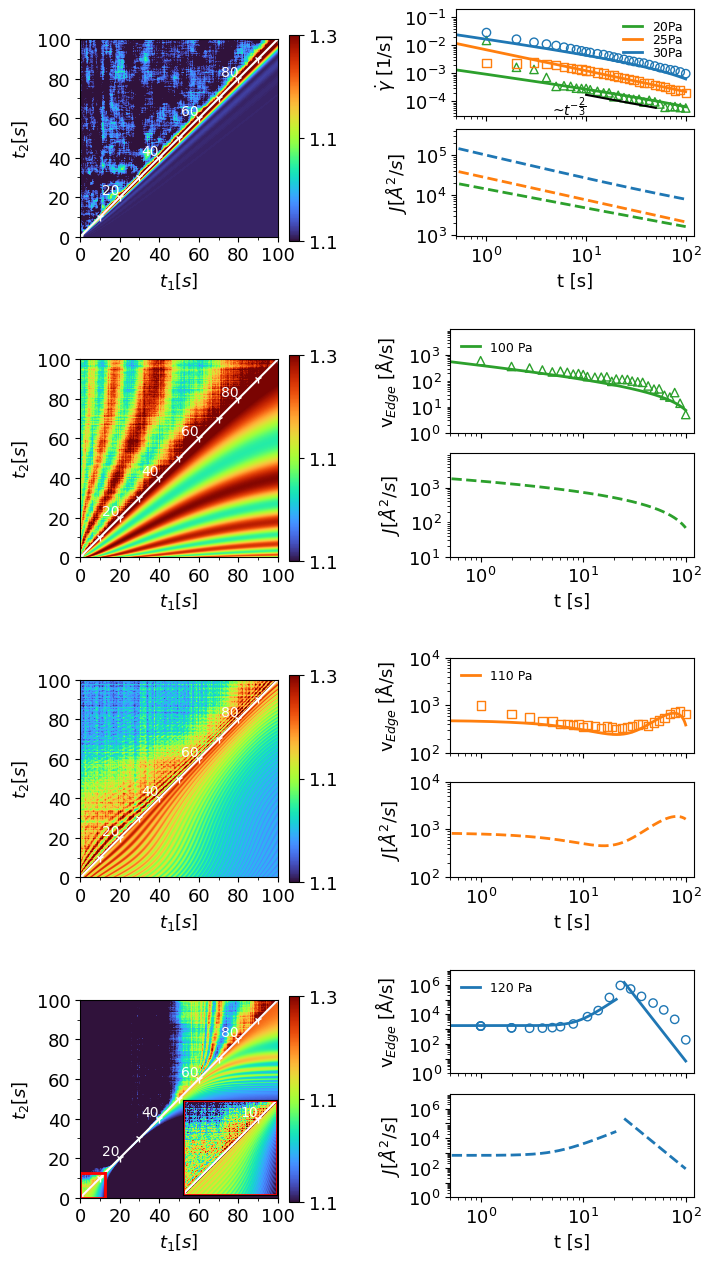

In [95]:
axis_fontsize = 13
fontsize = 14

alpha = 1
shrink = 0.8
SelectedPhiIdx = 2
legend_x = 0.42
legend_y = 0.34
startpoint = 250

fig = plt.figure(layout='constrained', figsize=(7, 12.5))
# fig.suptitle('fig')

subfigs = fig.subfigures(4, 2, wspace=0.08, hspace = 0.1)

subfigsnest = subfigs[0][0]
axsnest0 = subfigsnest.add_subplot(1,1,1)
ax1 = axsnest0
plot_fig1()

gs = subfigsnest = subfigs[0][1].add_gridspec(2, 1, hspace=0, wspace=0, height_ratios=[1, 1])
(ax2,ax1) = gs.subplots(sharex='col', sharey='row')
plot_fig2()

subfigsnest = subfigs[1][0]
axsnest0 = subfigsnest.add_subplot(1,1,1)
ax4 = axsnest0
plot_fig3()

gs = subfigsnest = subfigs[1][1].add_gridspec(2, 1, hspace=0, wspace=0, height_ratios=[1, 1])
(ax3,ax2) = gs.subplots(sharex='col', sharey='row')
plot_fig4()

subfigsnest = subfigs[2][0]
axsnest0 = subfigsnest.add_subplot(1,1,1)
ax5 = axsnest0
plot_fig5()

gs = subfigsnest = subfigs[2][1].add_gridspec(2, 1, hspace=0, wspace=0, height_ratios=[1, 1])
(ax3,ax2) = gs.subplots(sharex='col', sharey='row')
plot_fig6()

subfigsnest = subfigs[3][0]
axsnest0 = subfigsnest.add_subplot(1,1,1)
ax6 = axsnest0
plot_fig7()

gs = subfigsnest = subfigs[3][1].add_gridspec(2, 1, hspace=0, wspace=0, height_ratios=[1, 1])
(ax3,ax2) = gs.subplots(sharex='col', sharey='row')
plot_fig8()

plt.savefig('fig2.png', dpi=600, bbox_inches='tight')